<Axes3D: >

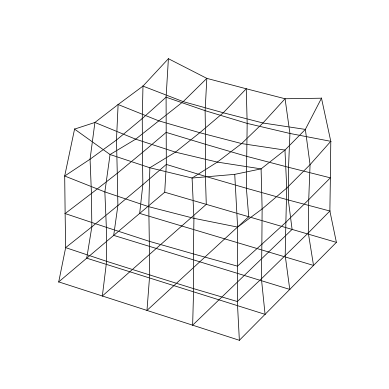

In [1]:
## HARDCODED FORCE IMPLECATION FROM ONE DIRECTION ##

import numpy as np
from skfem import *
from skfem.models.elasticity import (linear_elasticity, lame_parameters, linear_stress)
from skfem.helpers import dot, sym_grad
from skfem.visuals.matplotlib import draw
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Initialisieren des Netzes und der Elemente
m = MeshHex().refined(2)
e1 = ElementHex1()
e = ElementVector(e1)
ib = Basis(m, e, MappingIsoparametric(m, e1), 3)

# Materialparameter
young_modulus = 31.1e9
nu = 0.35

# assemblierung stiffness matrix
K = asm(linear_elasticity(*lame_parameters(young_modulus, nu)), ib)

# label dofs
dofs = {
    'left': ib.get_dofs(lambda x: x[0] == 0.0),
    'right': ib.get_dofs(lambda x: x[0] == 1.0),
    'up': ib.get_dofs(lambda x: x[2] == 1.0),
    'down': ib.get_dofs(lambda x: x[2] == 0.0),
    'front': ib.get_dofs(lambda x: x[1] == 0.0),
    'back': ib.get_dofs(lambda x: x[1] == 1.0)
}

u = ib.zeros()

# force applied to knots
Kraft = 50000000  
F = np.zeros(u.shape)
up_dofs = dofs['up'].nodal['u^3']
F[up_dofs] = Kraft

# Randbedingungen fixieren
fixed_dofs = np.hstack([dofs['down'].all()])
u[fixed_dofs] = 0

#set dofs and solve DGL
free_dofs = np.setdiff1d(np.arange(K.shape[0]), fixed_dofs)
K_free = K[free_dofs][:, free_dofs]
F_free = F[free_dofs]
u_free = solve(K_free, F_free)
u[free_dofs] = u_free

# calculating upper shift only for the hard coded example
verschiebung_oben = u[up_dofs]


# implement shifts
u[up_dofs] = verschiebung_oben


I = ib.complement_dofs(np.concatenate((dofs['up'], dofs['down'])))
u = solve(*condense(K, x=u, I=I))


factor = 5
m_defo = m.translated(factor * u[ib.nodal_dofs])
draw(m_defo)

In [31]:
##  TETMESH IN THE WILD LIBRARY INPUT AND TEST ##

import pytetwild
import meshio
import numpy as np
from skfem import *
def TetMesh(input_file, output_file):
    
    stl : meshio.Mesh = meshio.read(f"C:/Users/AlexP/Desktop/BA/STL_Files/{input_file}")
    vertices, tetrahedras = pytetwild.tetrahedralize(stl.points, stl.cells_dict["triangle"])

    cells = meshio.CellBlock('tetra', tetrahedras)
    # write intermediate file
    meshio.write_points_cells(f"C:/Users/AlexP/Desktop/BA/Meshes/{output_file}", vertices, [cells])

    # in case you want to directly continue with it
    p = np.array([vertices[:,0],  vertices[:,1],  vertices[:,2]], dtype=np.float64)
    t = np.array(tetrahedras, dtype=np.float64).T
    m = MeshTet(p, t)
    return m 

input_file = "egg.stl"
output_file = "egg.msh"
mesh = TetMesh(input_file, output_file)



Starting tetrahedralization process...


Transforming over 1000 elements to C_CONTIGUOUS.


Tetrahedralization complete.
Number of vertices: 2928
Number of tetrahedra: 11450
Prepared numpy array for points.
Prepared numpy array for tetrahedra.
Tetrahedralization process completed successfully.


In [57]:
import numpy as np
from skfem import *


from skfem.models.elasticity import (linear_elasticity, lame_parameters, linear_stress)
from skfem.helpers import dot, sym_grad, grad, transpose
from skfem.visuals.matplotlib import draw
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

transverse_modulus = 2432.29e6 #Pa
principal_modulus = 2367.10e6 # Pa

transvere_poisson = 0.24
principal_poisson = 0.34

def transverse_isotropy(E1, E2, nu1, nu2):
    #E1->elasticity modulus in the isotropic plane
    #E2->e.m. in transverse axis
    C11 = E1*(1-nu2**2)/(1-nu1**2)
    C12 = E1*nu1/(1-nu1**2)
    C13 = E2*nu2/(1-nu2**2)
    C33 = E2/(1-nu2**2)
    C44 = E1/(2*(1+nu1))
    C66 = 0.5*(C11-C12)
    return C11, C12, C13, C33 , C44, C66

C11, C12, C13, C33 , C44, C66 = transverse_isotropy(transverse_modulus, principal_modulus, transvere_poisson, principal_poisson)

def Stiffnesstensor(C11, C12, C13, C33, C44, C66):
    C = np.zeros((3,3,3,3))
    C[0, 0, 0, 0] = C11
    C[1, 1, 1, 1] = C11
    C[0, 0, 1, 1] = C12
    C[1, 1, 0, 0] = C12
    C[0, 0, 2, 2] = C13
    C[2, 2, 0, 0] = C13
    C[1, 1, 2, 2] = C13
    C[2, 2, 1, 1] = C13
    C[2, 2, 2, 2] = C33
    C[1, 2, 1, 2] = C44
    C[2, 1, 2, 1] = C44
    C[2, 1, 1, 2] = C44
    C[1, 2, 2, 1] = C44
    C[0, 2, 0, 2] = C44
    C[2, 0, 2, 0] = C44
    C[2, 0, 0, 2] = C44
    C[0, 2, 2, 0] = C44
    C[0, 1, 0, 1] = C66
    C[1, 0, 1, 0] = C66
    C[1, 0, 0, 1] = C66
    C[0, 1, 1, 0] = C66
    return C 


C = Stiffnesstensor(C11, C12, C13, C33 , C44, C66 )







def fem_in_directions(mesh_path,app_force):
    #mesh_path wieder hinzufügen, falls gewollt
    # stl : meshio.Mesh = meshio.read(f"C:/Users/AlexP/Desktop/BA/STL_Files/{input_file}")
    # vertices, tetrahedras = pytetwild.tetrahedralize(stl.points, stl.cells_dict["triangle"])

    # cells = meshio.CellBlock('tetra', tetrahedras)
    # p = np.array([vertices[:,0],  vertices[:,1],  vertices[:,2]], dtype=np.float64)
    # t = np.array(tetrahedras, dtype=np.float64).T
    # m = MeshTet(p, t)
    
    
    # Load the mesh
    m = MeshTet()
    m = m.load(mesh_path)
    #m = MeshTet().refined(3)
    # Define elements
    e1 = ElementTetP1()
    e = ElementVector(e1)
    ib = Basis(m, e, MappingIsoparametric(m, e1), 3)
    
    @BilinearForm
    def anisotropic(u, v, _):
        epsu = 0.5 * (grad(u) + transpose(grad(u)))
        epsv = 0.5 * (grad(v) + transpose(grad(v)))
        return np.einsum('ijkl,ij...,kl...', C, epsu, epsv)


    # assemblierung stiffness matrix
    K = asm(anisotropic, ib)
    # Assemble the stiffness matrix
    #K = asm(linear_elasticity(*lame_parameters(young_modulus, nu)), ib)

    # Define DOFs
    dofs = {
        'left': ib.get_dofs(lambda x: np.isclose(x[0], x[0].min())),
        'right': ib.get_dofs(lambda x: np.isclose(x[0], x[0].max())),
        'up': ib.get_dofs(lambda x: np.isclose(x[1], x[1].max())),
        'down': ib.get_dofs(lambda x: np.isclose(x[1], x[1].min())),
        'front': ib.get_dofs(lambda x: np.isclose(x[2], x[2].max())),
        'back': ib.get_dofs(lambda x: np.isclose(x[2], x[2].min()))
    }

    # Define displacements
    displacements = {
        'left': ('right', 'u^1', app_force),
        'right': ('left', 'u^1', -app_force),
        'up': ('down', 'u^2', -app_force),
        'down': ('up', 'u^2', app_force),
        'front': ('back', 'u^3', -app_force),
        'back': ('front', 'u^3', app_force)
    }

    # Scale factor for translation
    sf = 1

    for direction, (opposite, component, force_value) in displacements.items():
        u = ib.zeros()
        
        # Initialize force array
        F = np.zeros(u.shape)
        
        # Correctly index the nodal DOFs
        direction_dofs = dofs[direction].nodal[component].astype(int).flatten()
        F[direction_dofs] = force_value

        # Fix boundary conditions
        fixed_dofs = np.hstack([dofs[opposite].all()])
        u[fixed_dofs] = 0

        # Set DOFs and solve the system
        free_dofs = np.setdiff1d(np.arange(K.shape[0]), fixed_dofs)
        K_free = K[free_dofs][:, free_dofs]
        F_free = F[free_dofs]
        u_free = solve(K_free, F_free)
        u[free_dofs] = u_free

        # Calculate final shift
        final_shift = u[direction_dofs]

        # Implement shifts
        u[direction_dofs] = final_shift

        # Flatten the DOFs to fix the issue
        I = ib.complement_dofs(np.concatenate([dofs[opposite].all(), dofs[direction].all()]))

        u = solve(*condense(K, x=u, I=I))

        # Translate and save the mesh
        m_shifted = m.translated(sf * u[ib.nodal_dofs])
        m_shifted.save(f"C:/Users/AlexP/Desktop/BA/Meshes/output2_{direction}.vtk", {"affected": u[ib.nodal_dofs][0]})
        print(direction, dofs[direction])

# Example usage
Force =9e6  # or any desired value
mesh_path = "C:/Users/AlexP/Desktop/BA/Meshes/Benchy.msh"
# young_modulus = 31.1e9
# nu = 0.35
input_file = "egg.stl"

fem_in_directions(mesh_path,Force)



left <skfem DofsView(MeshTet1, ElementVector) object>
  Number of nodal DOFs: 45 ['u^1' 'u^2' 'u^3']
right <skfem DofsView(MeshTet1, ElementVector) object>
  Number of nodal DOFs: 9 ['u^1' 'u^2' 'u^3']
up <skfem DofsView(MeshTet1, ElementVector) object>
  Number of nodal DOFs: 9 ['u^1' 'u^2' 'u^3']
down <skfem DofsView(MeshTet1, ElementVector) object>
  Number of nodal DOFs: 15 ['u^1' 'u^2' 'u^3']
front <skfem DofsView(MeshTet1, ElementVector) object>
  Number of nodal DOFs: 120 ['u^1' 'u^2' 'u^3']
back <skfem DofsView(MeshTet1, ElementVector) object>
  Number of nodal DOFs: 18 ['u^1' 'u^2' 'u^3']


In [63]:
import numpy as np
from skfem import *


from skfem.models.elasticity import (linear_elasticity, lame_parameters, linear_stress)
from skfem.helpers import dot, sym_grad, grad, transpose
from skfem.visuals.matplotlib import draw
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

transverse_modulus = 2432.29e6 #Pa
principal_modulus = 2367.10e6 # Pa

transvere_poisson = 0.24
principal_poisson = 0.34

def transverse_isotropy(E1, E2, nu1, nu2):
    #E1->elasticity modulus in the isotropic plane
    #E2->e.m. in transverse axis
    C11 = E1*(1-nu2**2)/(1-nu1**2)
    C12 = E1*nu1/(1-nu1**2)
    C13 = E2*nu2/(1-nu2**2)
    C33 = E2/(1-nu2**2)
    C44 = E1/(2*(1+nu1))
    C66 = 0.5*(C11-C12)
    return C11, C12, C13, C33 , C44, C66

C11, C12, C13, C33 , C44, C66 = transverse_isotropy(transverse_modulus, principal_modulus, transvere_poisson, principal_poisson)

def Stiffnesstensor(C11, C12, C13, C33, C44, C66):
    C = np.zeros((3,3,3,3))
    C[0, 0, 0, 0] = C11
    C[1, 1, 1, 1] = C11
    C[0, 0, 1, 1] = C12
    C[1, 1, 0, 0] = C12
    C[0, 0, 2, 2] = C13
    C[2, 2, 0, 0] = C13
    C[1, 1, 2, 2] = C13
    C[2, 2, 1, 1] = C13
    C[2, 2, 2, 2] = C33
    C[1, 2, 1, 2] = C44
    C[2, 1, 2, 1] = C44
    C[2, 1, 1, 2] = C44
    C[1, 2, 2, 1] = C44
    C[0, 2, 0, 2] = C44
    C[2, 0, 2, 0] = C44
    C[2, 0, 0, 2] = C44
    C[0, 2, 2, 0] = C44
    C[0, 1, 0, 1] = C66
    C[1, 0, 1, 0] = C66
    C[1, 0, 0, 1] = C66
    C[0, 1, 1, 0] = C66
    return C 


C = Stiffnesstensor(C11, C12, C13, C33 , C44, C66 )







def fem_in_directions(input_file,app_force):
    #mesh_path wieder hinzufügen, falls gewollt
    stl : meshio.Mesh = meshio.read(f"C:/Users/AlexP/Desktop/BA/STL_Files/{input_file}")
    vertices, tetrahedras = pytetwild.tetrahedralize(stl.points, stl.cells_dict["triangle"])

    cells = meshio.CellBlock('tetra', tetrahedras)
    p = np.array([vertices[:,0],  vertices[:,1],  vertices[:,2]], dtype=np.float64)
    t = np.array(tetrahedras, dtype=np.float64).T
    m = MeshTet(p, t)
    
    
    # Load the mesh
    #m = MeshTet()
    #m = m.load(mesh_path)
    #m = MeshTet().refined(3)
    # Define elements
    e1 = ElementTetP1()
    e = ElementVector(e1)
    ib = Basis(m, e, MappingIsoparametric(m, e1), 3)
    
    @BilinearForm
    def anisotropic(u, v, _):
        epsu = 0.5 * (grad(u) + transpose(grad(u)))
        epsv = 0.5 * (grad(v) + transpose(grad(v)))
        return np.einsum('ijkl,ij...,kl...', C, epsu, epsv)


    # assemblierung stiffness matrix
    K = asm(anisotropic, ib)
    # Assemble the stiffness matrix
    #K = asm(linear_elasticity(*lame_parameters(young_modulus, nu)), ib)

    # Define DOFs
    dofs = {
        'left': ib.get_dofs(lambda x: np.isclose(x[0], x[0].min())),
        'right': ib.get_dofs(lambda x: np.isclose(x[0], x[0].max())),
        'up': ib.get_dofs(lambda x: np.isclose(x[1], x[1].max())),
        'down': ib.get_dofs(lambda x: np.isclose(x[1], x[1].min())),
        'front': ib.get_dofs(lambda x: np.isclose(x[2], x[2].max())),
        'back': ib.get_dofs(lambda x: np.isclose(x[2], x[2].min()))
    }

    # Define displacements
        # Define displacements
    displacements = {
        'left': ('right', 'u^1', app_force),
        'right': ('left', 'u^1', -app_force),
        'up': ('down', 'u^2', -app_force),
        'down': ('up', 'u^2', app_force),
        'front': ('back', 'u^3', -app_force),
        'back': ('front', 'u^3', app_force)
    }
    # Scale factor for translation
    sf = 1

    for direction, (opposite, component, force_value) in displacements.items():
        u = ib.zeros()
        
        # Initialize force array
        F = np.zeros(u.shape)
        
        # Correctly index the nodal DOFs
        direction_dofs = dofs[direction].nodal[component].astype(int).flatten()
        F[direction_dofs] = force_value

        # Fix boundary conditions
        fixed_dofs = np.hstack([dofs[opposite].all()])
        u[fixed_dofs] = 0

        # Set DOFs and solve the system
        free_dofs = np.setdiff1d(np.arange(K.shape[0]), fixed_dofs)
        K_free = K[free_dofs][:, free_dofs]
        F_free = F[free_dofs]
        u_free = solve(K_free, F_free)
        u[free_dofs] = u_free

        # Calculate final shift
        final_shift = u[direction_dofs]

        # Implement shifts
        u[direction_dofs] = final_shift

        # Flatten the DOFs to fix the issue
        I = ib.complement_dofs(np.concatenate([dofs[opposite].all(), dofs[direction].all()]))

        u = solve(*condense(K, x=u, I=I))

        # Translate and save the mesh
        m_shifted = m.translated(sf * u[ib.nodal_dofs])
        m_shifted.save(f"C:/Users/AlexP/Desktop/BA/Meshes/output3_{direction}.vtk", {"affected": u[ib.nodal_dofs][0]})
        print(direction, dofs[direction])
        print(u)

# Example usage
Force = 9e6  # or any desired value
mesh_path = "C:/Users/AlexP/Desktop/BA/Meshes/cube.msh"
# young_modulus = 31.1e9
# nu = 0.35
input_file = "egg.stl"

fem_in_directions(input_file,Force)


Starting tetrahedralization process...


Transforming over 1000 elements to C_CONTIGUOUS.


Tetrahedralization complete.
Number of vertices: 2969
Number of tetrahedra: 11619
Prepared numpy array for points.
Prepared numpy array for tetrahedra.
Tetrahedralization process completed successfully.
left <skfem DofsView(MeshTet1, ElementVector) object>
  Number of nodal DOFs: 9 ['u^1' 'u^2' 'u^3']
[0.06458449 0.78983792 0.19558332 ... 0.25530582 0.09265981 0.03276836]
right <skfem DofsView(MeshTet1, ElementVector) object>
  Number of nodal DOFs: 9 ['u^1' 'u^2' 'u^3']
[ 0.          0.          0.         ...  0.14286904 -0.60145222
 -0.11027864]
up <skfem DofsView(MeshTet1, ElementVector) object>
  Number of nodal DOFs: 9 ['u^1' 'u^2' 'u^3']
[ 0.27113215  0.23712703  0.08810954 ...  0.40157452 -0.27146322
  0.15542923]
down <skfem DofsView(MeshTet1, ElementVector) object>
  Number of nodal DOFs: 9 ['u^1' 'u^2' 'u^3']
[-0.30795512  0.35959286 -0.24949229 ... -0.16245636 -0.25599008
 -0.09603914]
front <skfem DofsView(MeshTet1, ElementVector) object>
  Number of nodal DOFs: 9 ['u^1' '

numpy.ndarray

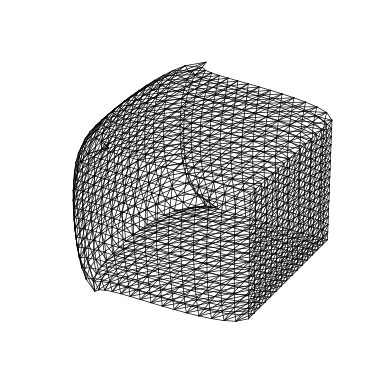

In [38]:
##Von Mises yielding stress calculation for every element
import numpy as np
from skfem import *
from skfem.helpers import dot, grad, div
from skfem.models.poisson import *
from scipy.sparse import spmatrix
from scipy.sparse.linalg import LinearOperator
from skfem.models.elasticity import linear_elasticity, lame_parameters
import meshio
from skfem.visuals.matplotlib import draw
m = MeshTet()
m = m.load("C:/Users/AlexP/Desktop/BA/Meshes/Cube.vtk")

e1 = ElementTetP1() # ElementHex1() # ElementTetP1()
e = ElementVector(e1)
ib = Basis(m, e, MappingIsoparametric(m, e1), 3)

young_modulus = 3e9
poisson_ratio = 0.33


K = asm(linear_elasticity(*lame_parameters(young_modulus, poisson_ratio)), ib) # young's modulus given in GPa, Poisson ratio for PLA

dofs = {
'left': ib.get_dofs(lambda x: np.isclose(x[0], x[0].min())),
'right': ib.get_dofs(lambda x: np.isclose(x[0], x[0].max())),
}

u = ib.zeros()


Kraft = 5000000
F = np.zeros(u.shape)
left_dofs = dofs['left'].nodal['u^1']
F[left_dofs] = Kraft

fixed_dofs = np.hstack([dofs['right'].all()])
u[fixed_dofs] = 0

#set dofs and solve DGL
free_dofs = np.setdiff1d(np.arange(K.shape[0]), fixed_dofs)
K_free = K[free_dofs][:, free_dofs]
F_free = F[free_dofs]
u_free = solve(K_free, F_free)
u[free_dofs] = u_free


verschiebung_links = u[left_dofs]


u[left_dofs] = verschiebung_links

I = ib.complement_dofs(dofs)

u = solve(*condense(K, x=u, I=I))



sf = 1.0
m = m.translated(sf * u[ib.nodal_dofs])
draw(m)

C = linear_stress(*lame_parameters(young_modulus, poisson_ratio))
s = {}
dgb = ib.with_element(ElementTetP0())
up = ib.interpolate(u)

for i in [0, 1]:
    for j in [0, 1]:
        s[i, j] = dgb.project(C(sym_grad(up))[i, j])

s[2, 2] = poisson_ratio * (s[0, 0] + s[1, 1])

vonmises = np.sqrt(.5 * ((s[0, 0] - s[1, 1]) ** 2 +
                          (s[1, 1] - s[2, 2]) ** 2 +
                          (s[2, 2] - s[0, 0]) ** 2 +
                          6. * s[0, 1] ** 2))


type(vonmises)

In [53]:
def yield_stress(array, x):
    e = []
    p = []
    for i in range(len(array)):
        if array[i] > x:
            p.append(i)
        else:
            e.append(i)
    return p, e

# Example usage
yield_stress_value = 2e9
plastisch, elastisch = yield_stress(vonmises, yield_stress_value)

print(len(plastisch), len(elastisch))

57 20193


In [1]:
## HARDCODED FORCE IMPLECATION FROM ONE DIRECTION WITH VON MISES YIELD STRESS ##

import numpy as np
from skfem import *
from skfem.models.elasticity import (linear_elasticity, lame_parameters, linear_stress)
from skfem.helpers import dot, sym_grad
from skfem.visuals.matplotlib import draw
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Initialisieren des Netzes und der Elemente
m = MeshHex().refined(2)
e1 = ElementHex1()
e = ElementVector(e1)
ib = Basis(m, e, MappingIsoparametric(m, e1), 3)

# Materialparameter
young_modulus = 31.1e9
nu = 0.35

# assemblierung stiffness matrix
K = asm(linear_elasticity(*lame_parameters(young_modulus, nu)), ib)

# label dofs
dofs = {
    'left': ib.get_dofs(lambda x: x[0] == 0.0),
    'right': ib.get_dofs(lambda x: x[0] == 1.0),
    'up': ib.get_dofs(lambda x: x[2] == 1.0),
    'down': ib.get_dofs(lambda x: x[2] == 0.0),
    'front': ib.get_dofs(lambda x: x[1] == 0.0),
    'back': ib.get_dofs(lambda x: x[1] == 1.0)
}

u = ib.zeros()

# force applied to knots
Kraft = 1e8 
F = np.zeros(u.shape)
up_dofs = dofs['up'].nodal['u^3']
F[up_dofs] = Kraft

# Randbedingungen fixieren
fixed_dofs = np.hstack([dofs['down'].all()])
u[fixed_dofs] = 0

#set dofs and solve DGL
free_dofs = np.setdiff1d(np.arange(K.shape[0]), fixed_dofs)
K_free = K[free_dofs][:, free_dofs]
F_free = F[free_dofs]
u_free = solve(K_free, F_free)
u[free_dofs] = u_free

# calculating upper shift only for the hard coded example
verschiebung_oben = u[up_dofs]


# implement shifts
u[up_dofs] = verschiebung_oben

C = linear_stress(*lame_parameters(young_modulus, poisson_ratio))

I = ib.complement_dofs(np.concatenate((dofs['up'], dofs['down'])))
u = solve(*condense(K, x=u, I=I))


factor = 1
m_defo = m.translated(factor * u[ib.nodal_dofs])
draw(m_defo)
s = {}
dgb = ib.with_element(ElementHex1())
up = ib.interpolate(u)

for i in [0, 1]:
    for j in [0, 1]:
        s[i, j] = dgb.project(C(sym_grad(up))[i, j])

s[2, 2] = poisson_ratio * (s[0, 0] + s[1, 1])

vonmises = np.sqrt(.5 * ((s[0, 0] - s[1, 1]) ** 2 +
                          (s[1, 1] - s[2, 2]) ** 2 +
                          (s[2, 2] - s[0, 0]) ** 2 +
                          6. * s[0, 1] ** 2))
plastisch, elastisch = yield_stress(vonmises, 1e9)

print(plastisch, elastisch)

NameError: name 'poisson_ratio' is not defined